In [1]:
import os
import joblib
from joblib import Memory
import pandas as pd
import numpy
import sklearn, re

In [2]:
df = pd.read_csv('reviews_badminton/data.csv')

df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [3]:
df.shape

(8518, 8)

In [4]:
df = df.dropna(subset=['Review text'])

In [5]:
df['sentiment'] = df['Ratings'].apply(lambda x: 1 if x >= 3 else 0) # 1 is positive and 0 is negative

In [6]:
df

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings,sentiment
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4,1
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1,0
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1,0
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3,1
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1,0
...,...,...,...,...,...,...,...,...,...
8505,MD. Jabbar,Very Good,NaN,1.0,0.0,Sep 2016,Delivered before time but price is high from m...,3,1
8506,Abani Behera,Don't waste your money,NaN,0.0,2.0,Sep 2016,up to the mark but same is available in market...,4,1
8507,vishnu varma,Really Nice,"Certified Buyer, Agartala",0.0,1.0,Sep 2016,Nice delivery speedREAD MORE,5,1
8508,NaN,NaN,NaN,NaN,NaN,NaN,No complaints about the item . Its the best on...,5,1


In [7]:
df['sentiment'].value_counts(normalize=True)

1    0.874031
0    0.125969
Name: sentiment, dtype: float64

In [8]:
df.loc[4,'Review text']

"Over pricedJust â?¹620 ..from retailer.I didn't understand.. Wat is d advantage of buying dis frm flipkrtREAD MORE"

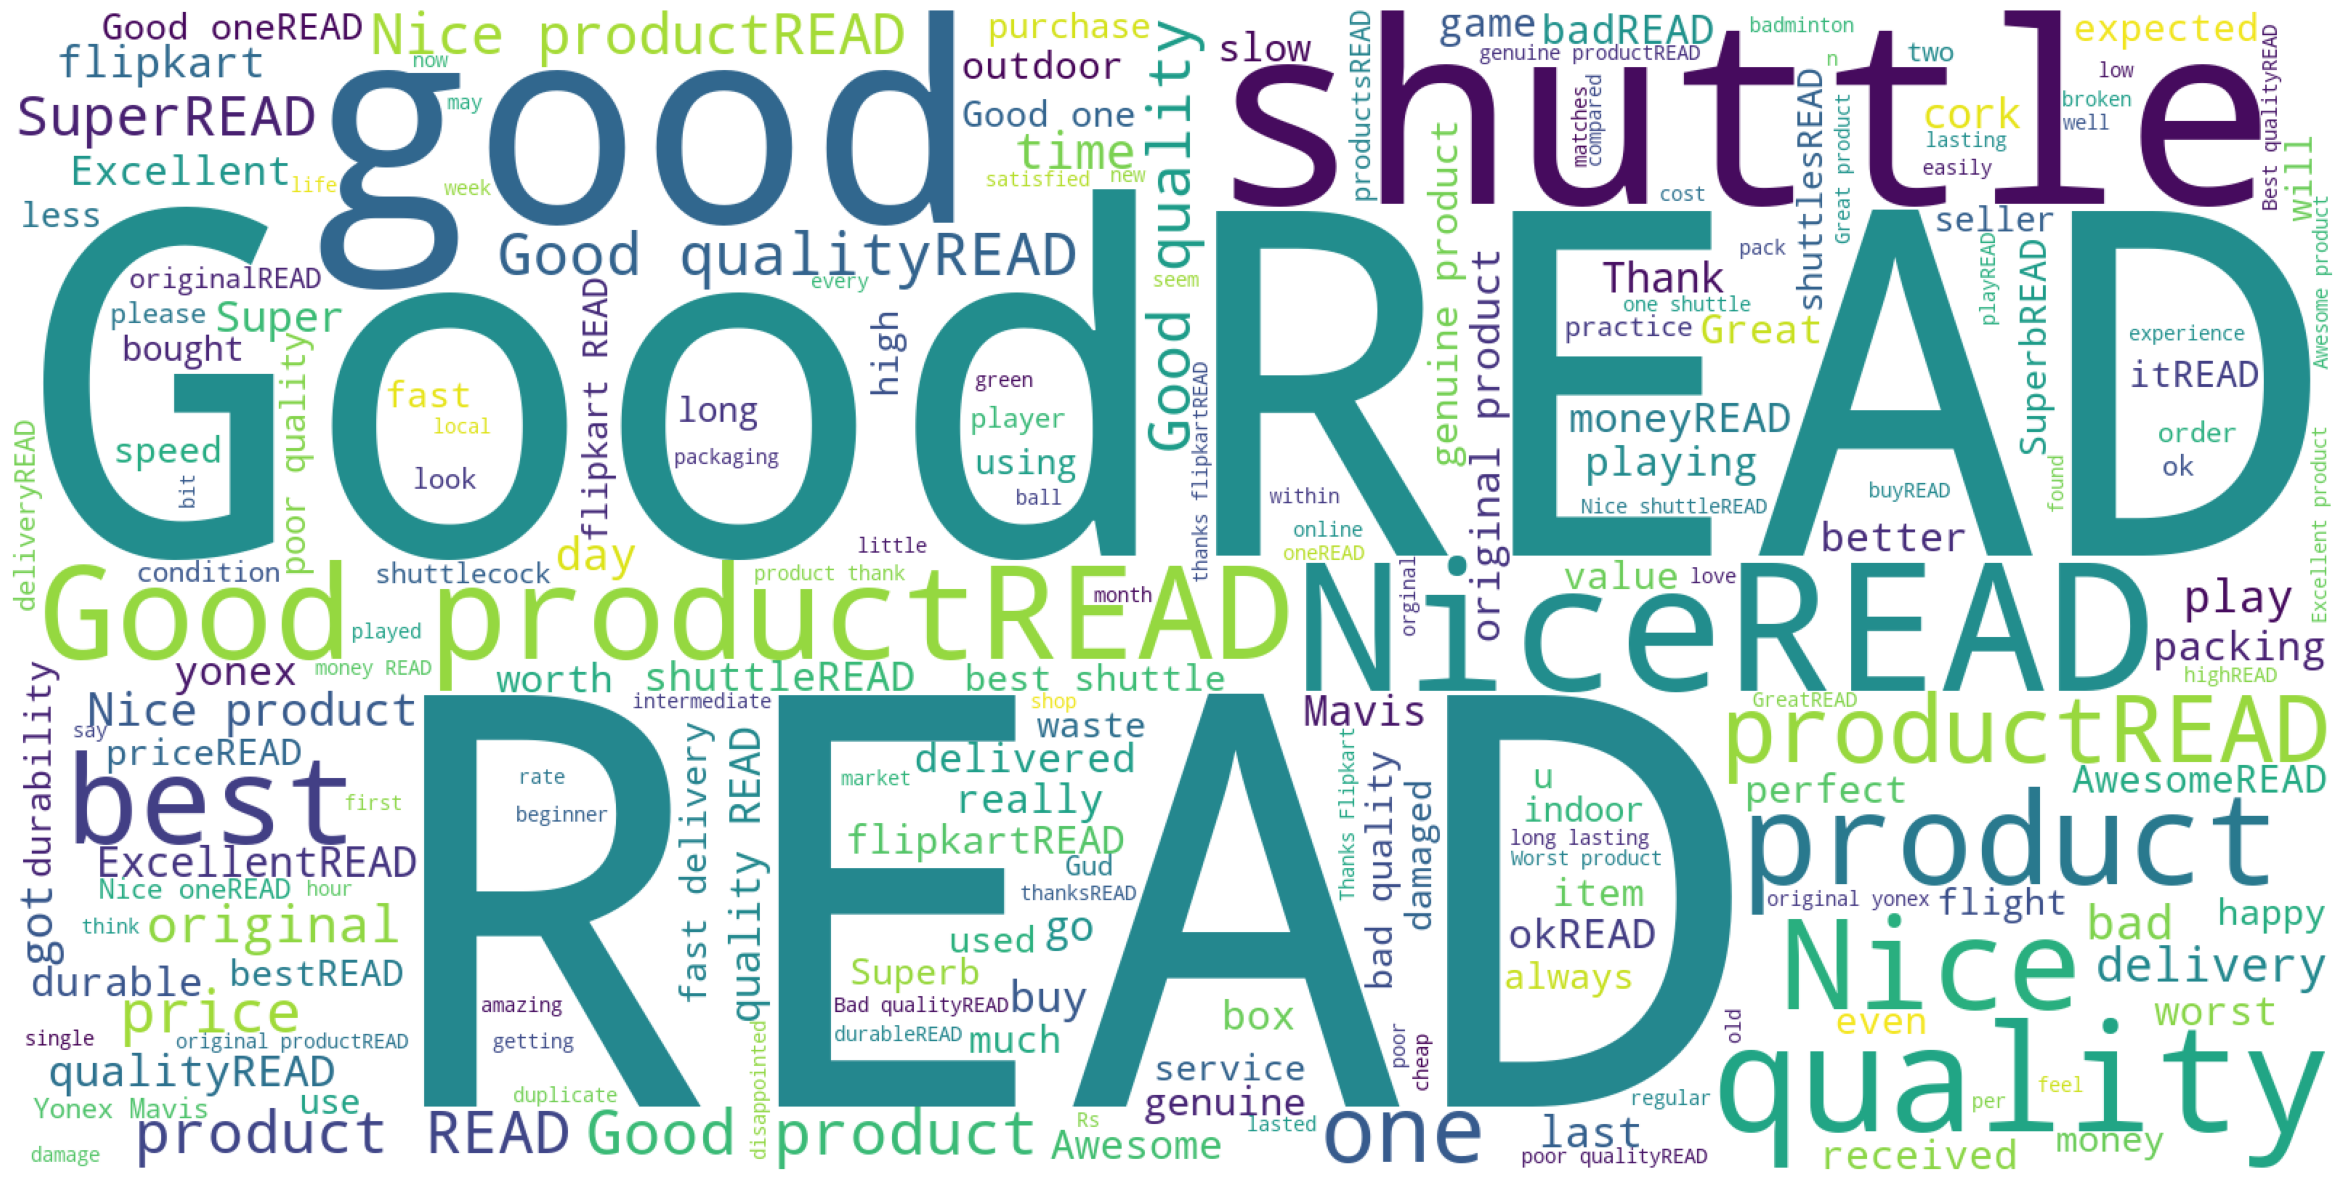

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df['Review text'] = df['Review text'].astype(str)

wc = WordCloud(background_color='white',
               width=1600,
               height=800).generate(' '.join(df['Review text']))


plt.figure(1,figsize=(30,20))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [10]:
X = df['Review text']
y = df['sentiment']

In [11]:
# Step 2: Split the data into train and test

from sklearn.model_selection import train_test_split

# split X and y into training and testing sets. 
# By default, it splits 75% training and 25% test
# random_state=1 for reproducibility

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6382,) (6382,)
(2128,) (2128,)


In [12]:
# Step 3: Data Preprocessing on train data (X_train)

import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

In [13]:
def clean(doc): # doc is a string of text
    # This text contains a lot of READ MORE tags.
    doc = doc.replace("READ MORE", " ")
    
    # Remove punctuation and numbers.
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)
#     doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])

    # Converting to lower case
    doc = doc.lower()
    
    # Tokenization
    tokens = nltk.word_tokenize(doc)

    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    
    # Join and return
    return " ".join(filtered_tokens)

In [14]:
# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer

# instantiate a vectorizer
vect = CountVectorizer(preprocessor=clean)

# use it to extract features from training data
%time X_train_dtm = vect.fit_transform(X_train)

print(X_train_dtm.shape)

Wall time: 4.52 s
(6382, 2500)


In [15]:
X_test_dtm = vect.transform(X_test)

print(X_test_dtm.shape)

(2128, 2500)


In [16]:
# Step 5: Building a Model (i.e. Train the classifier)

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")

Wall time: 2.04 ms


MultinomialNB()

In [17]:
# Step 6: Evaluate on train data

from sklearn import metrics
# make class predictions for X_train_dtm
y_train_pred = nb.predict(X_train_dtm)

metrics.accuracy_score(y_train, y_train_pred)

0.9359135067376998

Text(0.5, 23.52222222222222, 'Predicted')

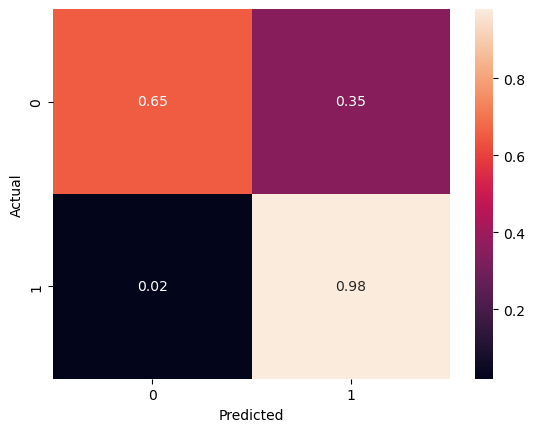

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [19]:
# Step 7: Evaluate on test data

# make class predictions for X_test_dtm
y_test_pred = nb.predict(X_test_dtm)

metrics.accuracy_score(y_test, y_test_pred)

0.9130639097744361

Text(0.5, 23.52222222222222, 'Predicted')

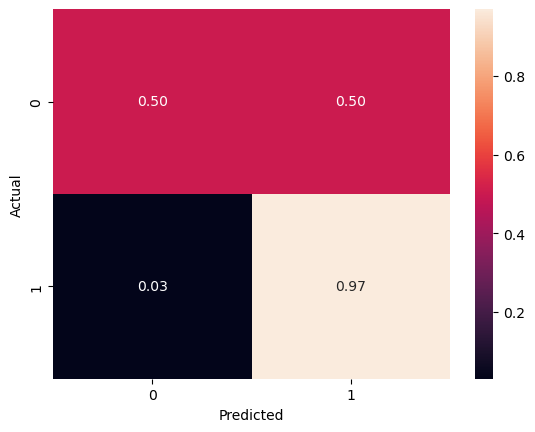

In [20]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [21]:
# # Understand that accuracy is influenced in the presence of data imbalance
# # Let's change the metric to F1 Score

print("Train Score (F1 Score):", metrics.f1_score(y_train, y_train_pred))

print("Test Score (F1 Score):", metrics.f1_score(y_test, y_test_pred))

print('\n Precision: ', metrics.precision_score(y_test, y_test_pred))
print('\n Recall: ', metrics.recall_score(y_test, y_test_pred))


Train Score (F1 Score): 0.9637892872952634
Test Score (F1 Score): 0.9515326172386692

 Precision:  0.934156378600823

 Recall:  0.9695675387079552


In [22]:
# Improving the efficiency by applying cleaning the text data before hand

%time X_train_clean = X_train.apply(lambda doc: clean(doc))

Wall time: 2.47 s


In [23]:
%time X_test_clean = X_test.apply(lambda doc: clean(doc))

Wall time: 828 ms


In [24]:
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import GridSearchCV

In [25]:
import warnings

warnings.filterwarnings('ignore')

In [45]:
# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'random_forest': Pipeline([
    ('vectorization', CountVectorizer()),
    ('classifier', RandomForestClassifier())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory),
    'svc': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', SVC())
    ], memory=memory),
    'knn': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', KNeighborsClassifier())
    ], memory=memory)
}
# Define parameter grid for each algorithm
param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__alpha' : [1, 10]
        }
    ],
    'decision_tree': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'random_forest': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_features': ['auto', 'sqrt', 'log2']

        }
    ],
    'logistic_regression': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__C': [0.1, 1, 10], 
            'classifier__penalty': ['elasticnet'], 
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga'],
            'classifier__class_weight': ['balanced']
        }
    ],
    'svc': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'poly', 'rbf','sigmoid']

        }
    ],
    'knn': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__p': [1, 2] 

        }
    ]
}

# Perform GridSearchCV for each algorithm
best_models = {}

for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    grid_search = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=5, 
                               scoring='f1', 
                               return_train_score=True,
                               verbose=1
                              )
    
    %time grid_search.fit(X_train_clean, y_train)
    
    best_models[algo] = grid_search.best_estimator_
    
    print('Score on Test Data: ', grid_search.score(X_test_clean, y_test))

********** naive_bayes **********
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Wall time: 3.64 s
Score on Test Data:  0.9515326172386692
********** decision_tree **********
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Wall time: 13.7 s
Score on Test Data:  0.9483028720626633
********** random_forest **********
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Wall time: 13min 59s
Score on Test Data:  0.9516339869281046
********** logistic_regression **********
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Wall time: 5min 39s
Score on Test Data:  0.9351218176840953
********** svc **********
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Wall time: 6min 10s
Score on Test Data:  0.9535732916014606
********** knn **********
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Wall time: 3min 28s
Score on Test Data:  0.9504434011476265


In [46]:
for name, model in best_models.items():
    print(f"****{name}****")
    print(f"{model}")
    joblib.dump(model, f'best_models/{name}.pkl')
    model = joblib.load(f'best_models/{name}.pkl')
    %time y_test_pred = model.predict(X_test_clean)
    print("Train Score (F1)",metrics.f1_score(y_train, y_train_pred))
    print("Test Score (F1)", metrics.f1_score(y_test, y_test_pred))
    
    print("Model Size:", os.path.getsize(f'best_models/{name}.pkl'), "Bytes \n")

****naive_bayes****
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier', MultinomialNB(alpha=1))])
Wall time: 9 ms
Train Score (F1) 0.9637892872952634
Test Score (F1) 0.9515326172386692
Model Size: 144144 Bytes 

****decision_tree****
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', TfidfVectorizer(max_features=1500)),
                ('classifier', DecisionTreeClassifier(max_depth=10))])
Wall time: 9.15 ms
Train Score (F1) 0.9637892872952634
Test Score (F1) 0.9483028720626633
Model Size: 88401 Bytes 

****random_forest****
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1000)),
                ('classifier', RandomForestClassifier(max_features='log2'))])
Wall time: 106 ms
Train Score (F1) 0.9637892872952634
Test Score (F1) 0.9516339869281046
Model Size: 16776372 Bytes 

****logistic_regression**

In [56]:
# Deserialization- Testing the chosen model with New Data for prediction.

model = joblib.load('best_models/svc.pkl')


new_data = ["this*% is a$ bad$ #product1#"]
    
new_data_clean = [clean(doc) for doc in new_data]

prediction = model.predict(new_data)

print("Prediction:", prediction)

Prediction: [0]
